In [147]:
import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
import torchcde
from tqdm.notebook import tqdm
from scipy.signal import find_peaks
import MulensModel as mm
import corner
from model.utils import inference, get_loglik, get_peak_pred, plot_params, simulate_lc, infer_lgfs
from matplotlib.offsetbox import AnchoredText

torch.random.manual_seed(42)
np.random.seed(42)
plt.rcParams["font.family"] = "serif"
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'

In [149]:
with h5py.File('/work/hmzhao/irregular-lc/KMT-loc-test.h5', mode='r') as dataset_file:
    Y = torch.tensor(dataset_file['Y'][...])
    X = torch.tensor(dataset_file['X'][...])
# preprocess
nanind = torch.where(~torch.isnan(X[:, 0, 1]))[0]
# Y: t_0, t_E, u_0, rho, q, s, alpha, f_s

Y = Y[nanind]
X = X[nanind]

In [ ]:
chi2_list = []
for i in tqdm(range(Y.shape[0])):
    param = Y[i].tolist()
    single = mm.Model({'t_0': param[0], 'u_0': param[2], 't_E': param[1]})
    data = mm.MulensData([X[i, :, 0], X[i, :, 1], X[i, :, 2]], phot_fmt='mag')
    event_single = mm.Event([data], single)
    chi2 = event_single.get_chi2()
    chi2_list.append(chi2)
chi2_list = np.array(chi2_list)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [150]:
from model.locator import Locator
import torchcde
import os

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

checkpt = torch.load('/work/hmzhao/experiments/locator/experiment_54125.ckpt', map_location='cpu')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

X = X[:, :, :2]
train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(X)

model = Locator(device).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

Locator(
  (prefilter): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=reflect)
    (1): PReLU(num_parameters=1)
    (2): Conv1d(16, 16, kernel_size=(15,), stride=(1,), padding=(7,), padding_mode=reflect)
    (3): PReLU(num_parameters=1)
    (4): Conv1d(16, 1, kernel_size=(1,), stride=(1,), padding_mode=reflect)
    (5): PReLU(num_parameters=1)
  )
  (unet): UNET_1D(
    (AvgPool1D1): AvgPool1d(kernel_size=(1,), stride=(5,), padding=(0,))
    (AvgPool1D2): AvgPool1d(kernel_size=(1,), stride=(25,), padding=(0,))
    (AvgPool1D3): AvgPool1d(kernel_size=(1,), stride=(125,), padding=(0,))
    (layer1): Sequential(
      (0): conbr_block(
        (conv1): Conv1d(1, 128, kernel_size=(7,), stride=(1,), padding=(3,))
        (bn): InstanceNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu): PReLU(num_parameters=1)
      )
      (1): re_block(
        (cbr1): conbr_block(
          (conv1): Conv1d(128, 128, k

In [151]:
size = 4096 * 4
batchsize = 128
pred = torch.zeros((size, 2))
z = torch.zeros((batchsize, 2)).to(device)
model.eval()
model.plot = False
model.soft_threshold = True
model.threshold = 0.5
with torch.no_grad():
    for i in tqdm(range(size // batchsize)):
        batch = train_coeffs[i*batchsize:i*batchsize+batchsize].float().to(device)
        pred[i*batchsize:i*batchsize+batchsize] = model(batch, z)[0].detach().cpu()

  0%|          | 0/128 [00:00<?, ?it/s]

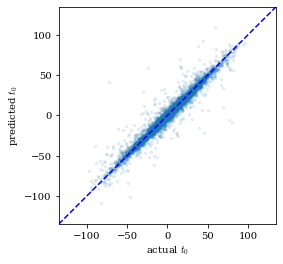

tensor([  6.4454, -11.7793, -10.9590, -16.2323,  28.0633, -13.8165,  -4.3302,
         -4.4253,  68.3217,  11.1644], dtype=torch.float64)
[  6.612844   -7.5739074 -12.863477  -19.698689   25.243948  -13.762337
  -4.489416   -3.7944164  66.036      12.1360855]
rmse of t_0  4.146906703224414


In [152]:
plt.axis('square')
plt.xlim(-135, 135)
plt.ylim(-135, 135)
plt.xlabel(r'actual $t_0$')
plt.ylabel(r'predicted $t_0$')
plt.scatter(Y[:size, 0], pred.numpy()[:size, 0], s=5, alpha=0.1)
plt.plot(np.linspace(-135, 135), np.linspace(-135, 135), color='b', linestyle='dashed')
plt.show()
print(Y[:10, 0])
print(pred.numpy()[:10, 0])
print('rmse of t_0 ', torch.sqrt(torch.mean((Y[:size, 0] -  pred.numpy()[:size, 0])**2, dim=0)).detach().cpu().item())
# print('mse of t_0 ', torch.mean((Y[:num, 0] -  pred_rand.numpy()[:num, 0])**2, dim=0).detach().cpu().item())

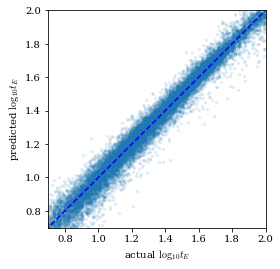

tensor([15.2177, 33.2011, 20.7851, 30.0660, 30.7152, 31.0744, 27.8128,  6.1498,
        74.5315, 25.3372], dtype=torch.float64)
[15.362198 32.50451  22.82913  30.139881 31.499458 34.47332  27.14737
  5.302164 80.93313  24.683002]
rmse of lgt_E:  0.05885156314958634


In [153]:
plt.axis('square')
plt.xlim(np.log10(5), 2)
plt.ylim(np.log10(5), 2)
plt.xlabel(r'actual $\log_{10}t_E$')
plt.ylabel(r'predicted $\log_{10}t_E$')
plt.scatter(np.log10(Y[:size, 1]), np.log10(pred.numpy()[:size, 1]), s=5, alpha=0.1)
plt.plot(np.linspace(0, 2), np.linspace(0, 2), color='b', linestyle='dashed')
plt.show()
print(Y[:10, 1])
print(pred.numpy()[:10, 1])
print('rmse of lgt_E: ', torch.sqrt((torch.mean((np.log10(Y[:size, 1]) -  np.log10(pred.numpy()[:size, 1]))**2, dim=0))).detach().cpu().item())
# print('mse of rand t_E: ', torch.mean((Y[:num, 1] -  pred_rand.numpy()[:num, 1])**2, dim=0).detach().cpu().item())

In [154]:
mse_unet = torch.sum((pred - Y[:size, [0, 1]])**2, dim=-1)

In [155]:
# transform
X_loc = X[:size].clone()
Y_loc = Y[:size].clone()
X_loc[:, :, 0] = (X_loc[:, :, 0] - pred[:, [0]]) / pred[:, [1]]
X_loc[:, :, 1] = (X_loc[:, :, 1] - 14.5 - 2.5 * torch.log10(Y_loc[:, [-1]])) / 0.2

X_loc_t = X[:size].clone()
Y_loc_t = Y[:size].clone()
X_loc_t[:, :, 0] = (X_loc_t[:, :, 0] - Y_loc[:, [0]]) / Y_loc[:, [1]]
X_loc_t[:, :, 1] = (X_loc_t[:, :, 1] - 14.5 - 2.5 * torch.log10(Y_loc[:, [-1]])) / 0.2

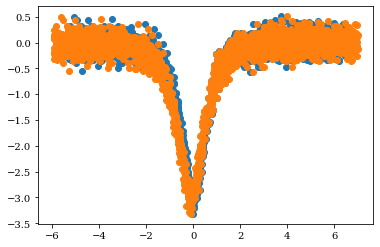

In [156]:
plt.scatter(X_loc[2, :, 0], X_loc[2, :, 1])
plt.scatter(X_loc_t[2, :, 0], X_loc_t[2, :, 1])

In [164]:
max_len = 0
lc_list = []
for i in tqdm(range(size)):
    # try:
    lc = X_loc_t[i]
    lc = lc[torch.where((lc[:, 0] <= 2) * (lc[:, 0] >= -2))]
    # depth = 3; window_length = max(len(lc)//100, 1)
    # lc = torchcde.logsig_windows(lc, depth, window_length=window_length)
    max_len = max(max_len, len(lc))
    lc = torch.cat([lc, lc[-1].expand(X_loc_t.shape[1] - len(lc), lc.shape[-1])])
    lc_list.append(lc)
    # except:
    #     print(X_loc[i, :, 0])
    #     plt.plot(X_loc[i, :, 0], X_loc[i, :, 1])
    #     plt.show()

X_loc_t = torch.stack(lc_list, dim=0)[:, :max_len]
Y_loc_t = Y[:size]

  0%|          | 0/16384 [00:00<?, ?it/s]

In [180]:
np.save('/work/hmzhao/X_loc_t.npy', X_loc_t)
np.save('/work/hmzhao/Y_loc_t.npy', Y_loc_t)

In [17]:
np.save('/work/hmzhao/X_loc.npy', X_loc)
np.save('/work/hmzhao/Y_loc.npy', Y_loc)

In [11]:
X_loc = np.load('/work/hmzhao/X_loc_t.npy', allow_pickle=True)
Y_loc = np.load('/work/hmzhao/Y_loc_t.npy', allow_pickle=True)

In [12]:
X = torch.tensor(X_loc)
Y = torch.tensor(Y_loc)
Y[:, 3:6] = torch.log10(Y[:, 3:6])
Y[:, -1] = torch.log10(Y[:, -1])
Y[:, 6] = Y[:, 6] / 180
Y = Y[:, [2, 4, 5, 6, 7]]
print('Shape of Y: ', Y.shape)

print(f'normalized X mean: {torch.mean(X[:, :, 1])}\nX std: {torch.mean(torch.std(X[:, :, 1], axis=0))}')
coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(X)

Shape of Y:  torch.Size([16384, 5])
normalized X mean: -0.7605260882567423
X std: 0.9086622926423984


In [12]:
from model.cde_mdn import CDE_MDN

device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")

checkpt = torch.load('/work/hmzhao/experiments/cde_mdn/experiment_l32nG12diag.ckpt', map_location='cpu')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

output_dim = Y.shape[-1]
input_dim = X.shape[-1]
latent_dim = ckpt_args.latents

model = CDE_MDN(input_dim, latent_dim, output_dim).to(device)
# model = CDE_MDN(input_dim, latent_dim, output_dim, 32).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

CDE_MDN(
  (cde_func): CDEFunc(
    (linear1): Linear(in_features=32, out_features=1024, bias=True)
    (relu1): PReLU(num_parameters=1)
    (resblocks): Sequential(
      (0): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (1): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (2): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
    )
    (relu2): PReLU(num_parameters=1)
    (linear2): Linear(in_features=1024, out_features=160, bias=True)
    (tanh): Tanh()
    (linear3): Linear(in_features=

In [13]:
size = X.shape[0]
pis, locs, scales = inference(model, size, min(4096, size), coeffs, device, full_cov=False)

  0%|          | 0/4 [00:00<?, ?it/s]

In [158]:
def prepare_lc_mdn(X, pis, locs):
    mag = X[:, :, 1] / 5 + 18
    flux = 10 ** (0.4 * (18 - mag))
    merr = torch.ones_like(mag) * 0.033
    ferr = merr*flux*np.log(10)/2.5
    # times, mag, flux, ferr
    lc = torch.stack([X[:, :, 0], mag, flux, ferr], dim=-1)
    first_indices = torch.arange(len(pis))[:, None]
    order = torch.argsort(pis, dim=-1, descending=True)
    pis = pis[first_indices, order]
    locs = locs[first_indices, order]
    return lc.numpy(), pis.numpy(), locs.numpy()

def prepare_lc(X):
    mag = X[:, :, 1] / 5 + 18
    flux = 10 ** (0.4 * (18 - mag))
    merr = torch.ones_like(mag) * 0.033
    ferr = merr*flux*np.log(10)/2.5
    # times, mag, flux, ferr
    lc = torch.stack([X[:, :, 0], mag, flux, ferr], dim=-1)
    return lc.numpy()

In [15]:
lc, pis_sort, locs_sort = prepare_lc_mdn(X[:size], pis, locs)

In [16]:
np.savez('/work/hmzhao/opt_input_joint.npz', lc=lc, locs=locs_sort)

In [165]:
lc = prepare_lc(X_loc_t[:size])

In [17]:
lc = np.load('/work/hmzhao/opt_input_joint.npz')['lc']

In [57]:
best_parameters = np.load('/work/hmzhao/best_parameters_joint.npy')
order = np.argsort(best_parameters[:, :, 0], axis=-1)
best_parameters_sort = best_parameters[np.arange(len(order))[:, None], order]
pred_chi2 = best_parameters_sort[:, 0, 2:]
order_close = np.argsort(((best_parameters[:, :, 2:] - Y[:4096*4, None, :-1].numpy())**2).sum(-1), axis=-1)
best_parameters_sort_close = best_parameters[np.arange(len(order))[:, None], order_close]
pred_close = best_parameters_sort_close[:, 0, 2:]

In [58]:
import VBBinaryLensing
def get_fsfb(amp, flux, ferr):
    sig2 = ferr**2
    wght = flux/sig2
    d = np.ones(2)
    d[0] = np.sum(wght*amp)
    d[1] = np.sum(wght)
    b = np.zeros((2,2))
    b[0,0] = np.sum(amp**2/sig2)
    b[0,1] = np.sum(amp/sig2)
    b[1,0] = b[0,1]
    b[1,1] = np.sum(1./sig2)
    c = np.linalg.inv(b)
    fs = np.sum(c[0]*d)
    fb = np.sum(c[1]*d)
    fserr = np.sqrt(c[0,0])
    fberr = np.sqrt(c[1,1])
    fmod = fs*amp+fb
    chi2 = np.sum((flux-fmod)**2/sig2)
    return chi2,fs,fb,fserr,fberr

def compute_model_lc(time_array, fitting_parameters, VBBL):
    u0, lgq, lgs, ad180 = fitting_parameters
    q, s = 10**lgq, 10**lgs
    alpha = ad180 * np.pi # convert to radian
    t0, te, rho = 0, 1, 1e-3
    tau = (time_array-t0)/te
    xs = tau*np.cos(alpha) - u0*np.sin(alpha)
    ys = tau*np.sin(alpha) + u0*np.cos(alpha)
    magnifications = np.array([VBBL.BinaryMag2(s, q, xs[i], ys[i], rho) for i in range(len(xs))])
    return magnifications

def compute_chisq(fitting_parameters, time, flux, ferr, VBBL, return_model=False):
    magnifications = compute_model_lc(time, fitting_parameters, VBBL)
    chi2, fs, fb, fserr, fberr = get_fsfb(magnifications, flux, ferr)
    if return_model:
        return chi2, fs, fb
    return chi2

In [59]:
def append_lgfs(lc, pred, verbose=True):
    lgfs = np.zeros((len(pred), 1))
    for i in tqdm(range(len(pred))):
        chi2, fs, fb = compute_chisq(pred[i, :4], lc[i, :, 0], lc[i, :, 2], lc[i, :, 3], VBBinaryLensing.VBBinaryLensing(), return_model=True)
        if fs / (fs + fb) < 0:
            if verbose:
                print(f'fs/fb < 0: {fs} {fb} {pred[i]} {chi2} {Y[i]}')
            lgfs[i] = 0
        else:
            lgfs[i] = np.log10(fs / (fs + fb))
    return np.hstack((pred, lgfs))
pred_chi2 = append_lgfs(lc, pred_chi2, False)
pred_close = append_lgfs(lc, pred_close, False)

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

In [171]:
def plot_params(num, Y, pred, chi2,
                title=None, figsize=(12, 8), labelsize=14, alpha=0.1, save=None, show=True,
                correct=False,
                rmse_plot=False, rmse_unet=None):
    pred = pred.copy()
    Y = Y.clone()
    if correct:
        for i in range(len(pred)):
            if pred[i, 1] > 0:
                pred[i, 1] = -pred[i, 1]
                pred[i, 3] = pred[i, 3] + 1
            if pred[i, 3] < 0:
                pred[i, 3] = - pred[i, 3]
            if pred[i, 3] > 2:
                pred[i, 3] = pred[i, 3] - 2

    valid = []
    ind_valid = np.ones((len(pred)))
    for i, (left, right) in enumerate([[0, 1], [-3, 0], [np.log10(0.3), np.log10(3)], [0, 2], [-1, 0]]):
        valid.append(np.sum(np.logical_and(pred[:, i] > left, pred[:, i] < right)) / len(pred))
        ind_valid = np.logical_and(ind_valid, np.logical_and(pred[:, i] > left, pred[:, i] < right))
    pred = pred[ind_valid]
    Y = Y[ind_valid]
    chi2 = chi2[ind_valid]
    if rmse_plot:
        rmse_unet = rmse_unet[ind_valid]
    
    rmse = []

    ind_chi2 = []
    # chi2_list = [(0, 500), (500, 1000), (1000, 2000), (2000, np.inf)]
    chi2_list = [(2000, np.inf), (1000, 2000), (500, 1000), (0, 500)]
    colors = ['lightgrey', 'darkgrey', 'grey', 'black']
    # colors = ['black', 'grey', 'darkgrey', 'lightgrey']
    for left, right in chi2_list:
        ind_chi2.append(np.logical_and(chi2 > left, chi2 < right))

    fig = plt.figure(figsize=figsize)
    axq = plt.subplot2grid(shape=(2, 3), loc=(0, 0), rowspan=1, colspan=1)
    axq.axis('square')
    axq.set_xlim(-3, 0)
    axq.set_ylim(-3, 0)
    axq.set_xlabel(r'true $\lg q$', fontsize=labelsize)
    axq.set_ylabel(r'predicted $\lg q$', fontsize=labelsize)
    for i, ind in enumerate(ind_chi2):
        axq.scatter(Y[:num, 1][ind], pred[:num, 1][ind], s=3, label=r'$\chi2 \in (%s, %s)$' % (
            chi2_list[i][0], chi2_list[i][1]
        ), alpha=alpha, rasterized=True, color=colors[i])
    axq.plot(np.linspace(-3, 0), np.linspace(-3, 0), color='b', linestyle='dashed')
    # axq.legend(loc='lower right', prop={'size': 7})
    rmse.append(np.sqrt(torch.mean((Y[:num, 1] -  pred[:num, 1])**2).detach().cpu().item()))
    at = AnchoredText(
        "RMSE=%.4f" '\n' 'Valid=%.3f' % (rmse[-1], valid[1]), prop=dict(size=12), frameon=False, loc='upper left')
    axq.add_artist(at)
    
    axs = plt.subplot2grid(shape=(2, 3), loc=(0, 1), rowspan=1, colspan=1)
    axs.axis('square')
    axs.set_xlim(np.log10(0.3), np.log10(3))
    axs.set_ylim(np.log10(0.3), np.log10(3))
    axs.set_xlabel(r'true $\lg s$', fontsize=labelsize)
    axs.set_ylabel(r'predicted $\lg s$', fontsize=labelsize)
    for i, ind in enumerate(ind_chi2):
        axs.scatter(Y[:num, 2][ind], pred[:num, 2][ind], s=3, label=r'$\chi2 \in (%s, %s)$' % (
            chi2_list[i][0], chi2_list[i][1]
        ), alpha=alpha, rasterized=True, color=colors[i])
    axs.plot(np.linspace(-0.6, 0.6), np.linspace(-0.6, 0.6), color='b', linestyle='dashed')
    # axs.legend(loc='lower right')
    rmse.append(np.sqrt(torch.mean((Y[:num, 2] -  pred[:num, 2])**2).detach().cpu().item()))
    at = AnchoredText(
        "RMSE=%.4f" '\n' 'Valid=%.3f' % (rmse[-1], valid[2]), prop=dict(size=12), frameon=False, loc='upper left')
    axs.add_artist(at)

    axu = plt.subplot2grid(shape=(2, 3), loc=(0, 2), rowspan=1, colspan=1)
    axu.axis('square')
    axu.set_xlim(0, 1)
    axu.set_ylim(0, 1)
    axu.set_xlabel(r'true $u_0$', fontsize=labelsize)
    axu.set_ylabel(r'predicted $u_0$', fontsize=labelsize)
    for i, ind in enumerate(ind_chi2):
        axu.scatter(Y[:num, 0][ind], pred[:num, 0][ind], s=3, label=r'$\chi2 \in (%s, %s)$' % (
            chi2_list[i][0], chi2_list[i][1]
        ), alpha=alpha, rasterized=True, color=colors[i])
    axu.plot(np.linspace(0, 1), np.linspace(0, 1), color='b', linestyle='dashed')
    # axu.legend(loc='lower right')
    rmse.append(np.sqrt(torch.mean((Y[:num, 0] -  pred[:num, 0])**2).detach().cpu().item()))
    at = AnchoredText(
        "RMSE=%.4f" '\n' 'Valid=%.3f' % (rmse[-1], valid[0]), prop=dict(size=12), frameon=False, loc='upper left')
    axu.add_artist(at)

    axa = plt.subplot2grid(shape=(2, 3), loc=(1, 0), rowspan=1, colspan=1)
    axa.axis('square')
    axa.set_xlim(0, 360)
    axa.set_ylim(0, 360)
    axa.set_xlabel(r'true $\alpha$ (deg)', fontsize=labelsize)
    axa.set_ylabel(r'predicted $\alpha$ (deg)', fontsize=labelsize)
    for i, ind in enumerate(ind_chi2):
        axa.scatter(Y[:num, 3][ind]*180, pred[:num, 3][ind]*180, s=3, label=r'$\chi2 \in (%s, %s)$' % (
            chi2_list[i][0], chi2_list[i][1]
        ), alpha=alpha, rasterized=True, color=colors[i])
    axa.plot(np.linspace(0, 360), np.linspace(0, 360), color='b', linestyle='dashed')
    # axa.legend(loc='lower right')
    rmse.append(np.sqrt(torch.mean((Y[:num, 3] -  pred[:num, 3])**2).detach().cpu().item())*180)
    at = AnchoredText(
        "RMSE=%.3f" '\n' 'Valid=%.3f' % (rmse[-1], valid[3]), prop=dict(size=12), frameon=False, loc='upper left')
    axa.add_artist(at)

    axf = plt.subplot2grid(shape=(2, 3), loc=(1, 1), rowspan=1, colspan=1)
    axf.axis('square')
    axf.set_xlim(-1, 0)
    axf.set_ylim(-1, 0)
    axf.set_xlabel(r'true $\lg f_s$', fontsize=labelsize)
    axf.set_ylabel(r'predicted $\lg f_s$', fontsize=labelsize)
    for i, ind in enumerate(ind_chi2):
        axf.scatter(Y[:num, 4][ind], pred[:num, 4][ind], s=3, label=r'$\chi2 \in (%s, %s)$' % (
            chi2_list[i][0], chi2_list[i][1]
        ), alpha=alpha, rasterized=True, color=colors[i])
    axf.plot(np.linspace(-1, 0), np.linspace(-1, 0), color='b', linestyle='dashed')
    rmse.append(np.sqrt((torch.mean((Y[:num, 4] -  pred[:num, 4])**2).detach().cpu().item())))
    at = AnchoredText(
        "RMSE=%.3f" '\n' 'Valid=%.3f' % (rmse[-1], valid[4]), prop=dict(size=12), frameon=False, loc='upper left')
    axf.add_artist(at)

    if rmse_plot:
        rmse_ncde = np.sqrt(np.sum((pred - Y.numpy())**2, axis=-1))
        ax_rmse = plt.subplot2grid(shape=(2, 3), loc=(1, 2), rowspan=1, colspan=1)
        plt.hist2d(np.log10(rmse_unet), np.log10(rmse_ncde), bins=100, cmap='gray_r')
        ax_rmse.axis('square')
        plt.xlim(-1.5, 1.5)
        plt.ylim(-2.6, 0.4)
        # print(rmse_ncde.shape, rmse_unet.shape)
        plt.xlabel(r'$\lg$ mse_locator', fontsize=labelsize)
        plt.ylabel(r'$\lg$ mse_estimator', fontsize=labelsize)
    

    plt.tight_layout()
        
    if title != None:
        fig.suptitle(title)

    if save != None:
        plt.savefig(save)
    
    if show:
        plt.show()
    else:
        plt.close()
    return rmse

ValueError: operands could not be broadcast together with shapes (13405,5) (13405,8) 

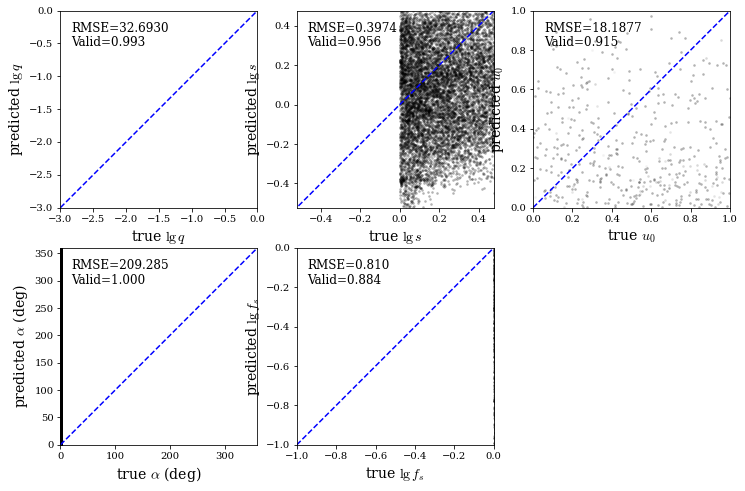

In [172]:
rmse_gap_chi2 = plot_params(num=4096*4, Y=Y[:4096*4], pred=pred_chi2, chi2=best_parameters_sort[:, 0, 0], alpha=0.2, correct=True, show=True,
                            save=None, title=None, rmse_plot=True, rmse_unet=np.sqrt(mse_unet.numpy()))

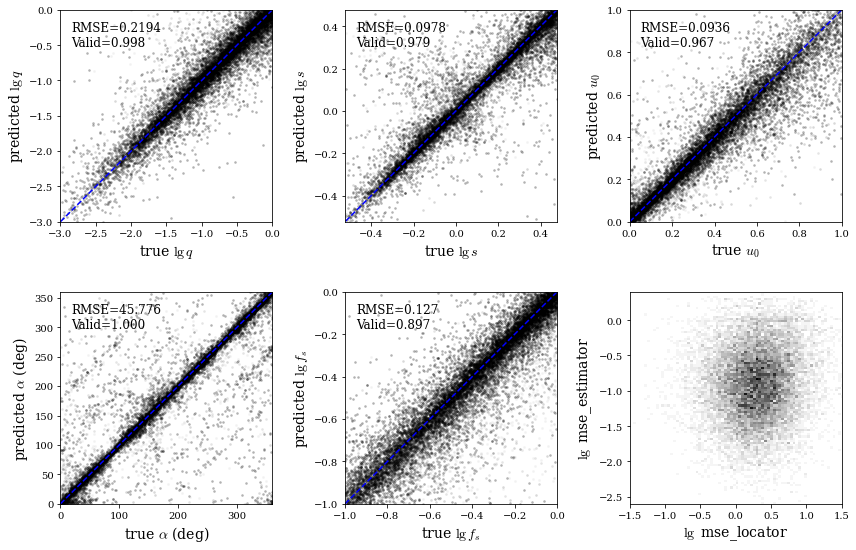

In [133]:
rmse_gap_close = plot_params(num=4096*4, Y=Y[:4096*4], pred=pred_close, chi2=best_parameters_sort_close[:, 0, 0], alpha=0.2, correct=True, show=True,
                            save=None, title=None, rmse_plot=True, rmse_unet=np.sqrt(mse_unet.numpy()))

In [167]:
n_points = []
for i in range(len(lc)):
    n_points.append(len(np.unique(lc[i, :, 0])))

In [168]:
lc.shape

(16384, 2000, 4)

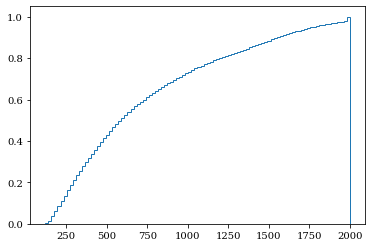

In [169]:
plt.hist(n_points, bins=100, density=True, cumulative=True, histtype='step', label='Cumulative')
plt.show()

In [134]:
np.log10(2194/1519)

0.15967884937590598

In [89]:
np.sum(pred_close[:, -1]==0) / pred_close.shape[0]

0.00103759765625

In [185]:
pred_global, pred_global_loglik, pred_close, pred_close_loglik = get_peak_pred(pis, locs, scales, Y, n_step=1000)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

In [186]:
print(pred_global_loglik.sum(dim=1).mean(), pred_close_loglik.sum(dim=1).mean())

tensor(11.0615) tensor(9.6877)


In [188]:
ind_largechi2 = (chi2_list > 0)[:size]

mse of log10q global:  0.11232767266694746
mse of log10q close:  0.06387790113580429
constraint 0.99285888671875
correct 0.8795106657650458
mse of log10s global:  0.02305617689443888
mse of log10s close:  0.0026650011007293044
constraint 0.98779296875
correct 0.8219846762234305
mse of u0:  0.014406342954379987
mse of u0:  0.005643853325152957
constraint 0.9901123046875
correct 0.8751078781901122
mse of alpha global:  7286.252746287453
mse of alpha close:  256.9185243777545
constraint 0.99029541015625
correct 0.7108166409861325
mse of log10fs global:  0.005588277488821747
mse of log10fs close:  0.003893817027193215


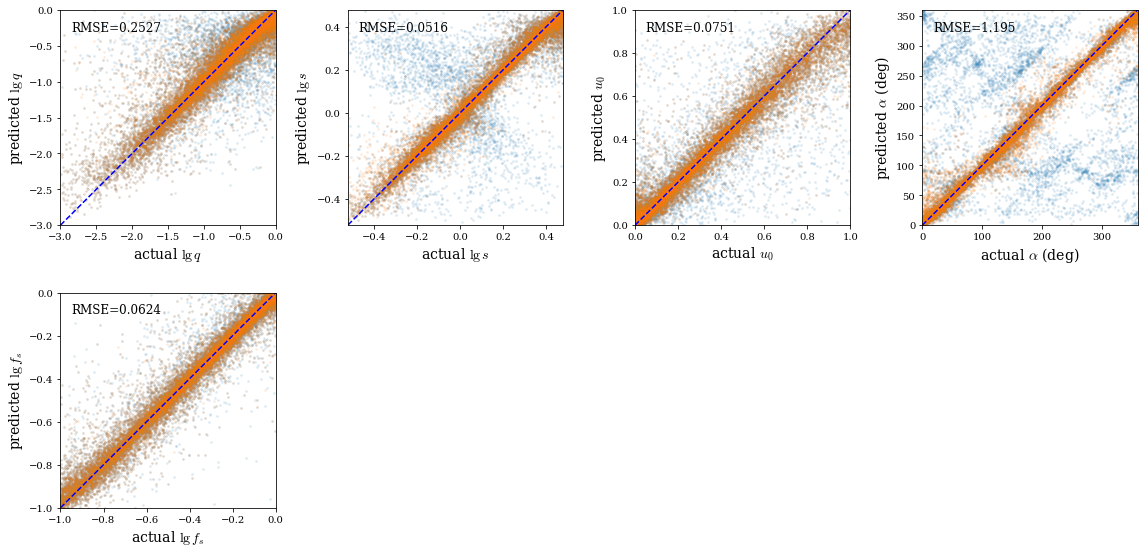

In [189]:
rmse = plot_params(size, Y[ind_largechi2], pred_global[ind_largechi2], pred_global_loglik[ind_largechi2], pred_close[ind_largechi2], pred_close_loglik[ind_largechi2], title=None)

mse of log10q global:  0.2611193051754688
mse of log10q close:  0.14122730104586023
constraint 0.00011947257005052803
correct 0.7949215591136989
mse of log10s global:  0.0751152717553152
mse of log10s close:  0.004699886026787815
constraint 0.00011978173406812602
correct 0.6239716083239232
mse of u0:  0.018033114751538647
mse of u0:  0.009065523468517458
constraint 0.00012109568114291755
correct 0.8450614329025052
mse of alpha global:  14718.647975484657
mse of alpha close:  1773.801791945396
constraint 0.00011415881349806236
correct 0.5062626946513202
mse of log10fs global:  0.015737585736748477
mse of log10fs close:  0.012627058288412386


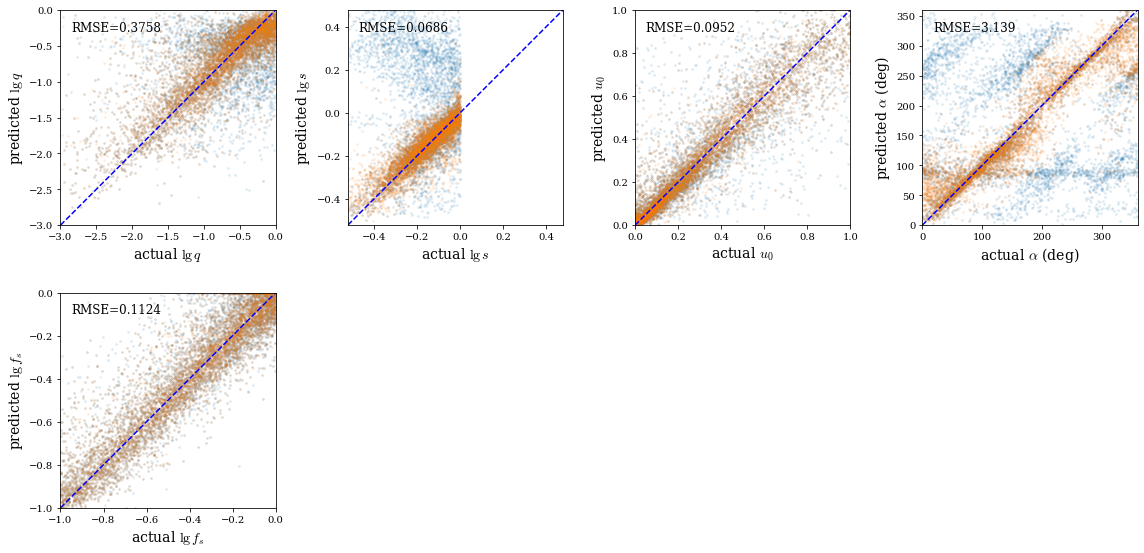

In [9]:
ind_smalls = torch.where(Y[:, 2] < 0)[0]
rmse = plot_params(int(torch.sum(ind_smalls)), Y[ind_smalls], pred_global[ind_smalls], pred_global_loglik[ind_smalls], pred_close[ind_smalls], pred_close_loglik[ind_smalls], title=None)

5523.633197040296
[0.4658012500306148, -3, -0.2306668891615047, -0.03831584250875388, 1.9152135855175778, -0.6325687291850852]
[0.4724724590778351, -3, -0.3323323428630829, -0.03183184191584587, 1.9019018411636353, -0.6456456780433655]


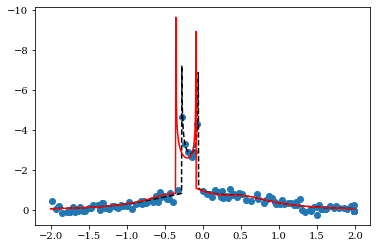

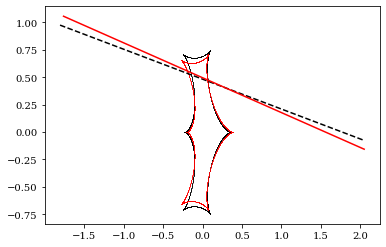

In [190]:
i = 0
print(chi2_list[i])
plt.scatter(X[i, :, 0], X[i, :, 1])
param = Y[i].tolist()
param.insert(1, -3)
print(param)
lc_true = simulate_lc(0, 1, *param)
param = pred_close[i].tolist()
param.insert(1, -3)
print(param)
lc = simulate_lc(0, 1, *param)
# param = pred_global[i].tolist()
# param.insert(1, -3)
# print(param)
# lc_g = simulate_lc(0, 1, *param)
plt.plot(lc_true[:, 0], lc_true[:, 1], color='black', linestyle='dashed')
plt.plot(lc[:, 0], lc[:, 1], color='red')
# plt.plot(lc_g[:, 0], lc_g[:, 1], color='orange')
plt.gca().invert_yaxis()
plt.show()
param_list = [Y[i].tolist(), pred_close[i].tolist()]
traj_color = ['black', 'red']
cau_color = ['black', 'red']
for j, params in enumerate(param_list):
    u_0, lgq, lgs, alpha_180, lgfs = params
    lgrho = -3
    parameters = {
                't_0': 0,
                't_E': 1,
                'u_0': u_0,
                'rho': 10**lgrho, 
                'q': 10**lgq, 
                's': 10**lgs, 
                'alpha': alpha_180*180,
            }
    modelmm = mm.Model(parameters, coords=None)
    if j == 0:
        modelmm.plot_trajectory(t_range=(-2, 2), caustics=False, arrow=False, color=traj_color[j], linestyle='dashed')
    else:
        modelmm.plot_trajectory(t_range=(-2, 2), caustics=False, arrow=False, color=traj_color[j])
    modelmm.plot_caustics(color=cau_color[j], s=0.3)

In [168]:
mse_ncde = torch.sum((pred_close - Y)**2, dim=-1)

Text(0, 0.5, 'lg mse_ncde')

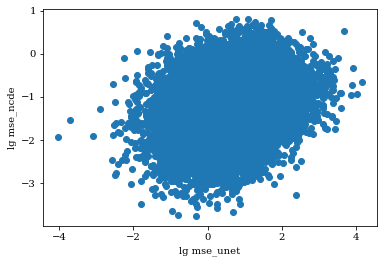

In [170]:
plt.scatter(np.log10(mse_unet), np.log10(mse_ncde))
plt.xlabel('lg mse_unet')
plt.ylabel('lg mse_ncde')